# Spatiotemporal machine learning

In this tutorial, you will learn how to use the [LandMapper  class](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.mapper.LandMapper.html#eumap.mapper.LandMapper) to train multiple machine learning models, fully compatible with [scikit-learn](https://scikit-learn.org/stable/) and able to produce spatial predictions for land cover in two pilot tiles (``5606`` and ``14580``), extracted from the ODSE [tiling system](https://gitlab.com/geoharmonizer_inea/spatial-layers#standard-tiling-system). The training will consider a subset of a [harmonized land cover samples based based on LUCAS and CORINE](https://zenodo.org/record/4740691#.YTKHwiM9CHs), which were overlaid with the DTM and Landsat raster layers produced in the scope of ODSE. A detailed description of the implemented workflow is available in [Witjes et al.,2021](https://www.researchsquare.com/article/rs-561383/v1), and the first version of the produced land cover maps (probabilities, uncertainties and dominant class) are accessible in the [ODSE Viewer](https://maps.opendatascience.eu/?base=OpenStreetMap%20(grayscale)&layer=Coniferous%20forest&zoom=4.5&center=55.2956,17.2777&opacity=85&time=2019).

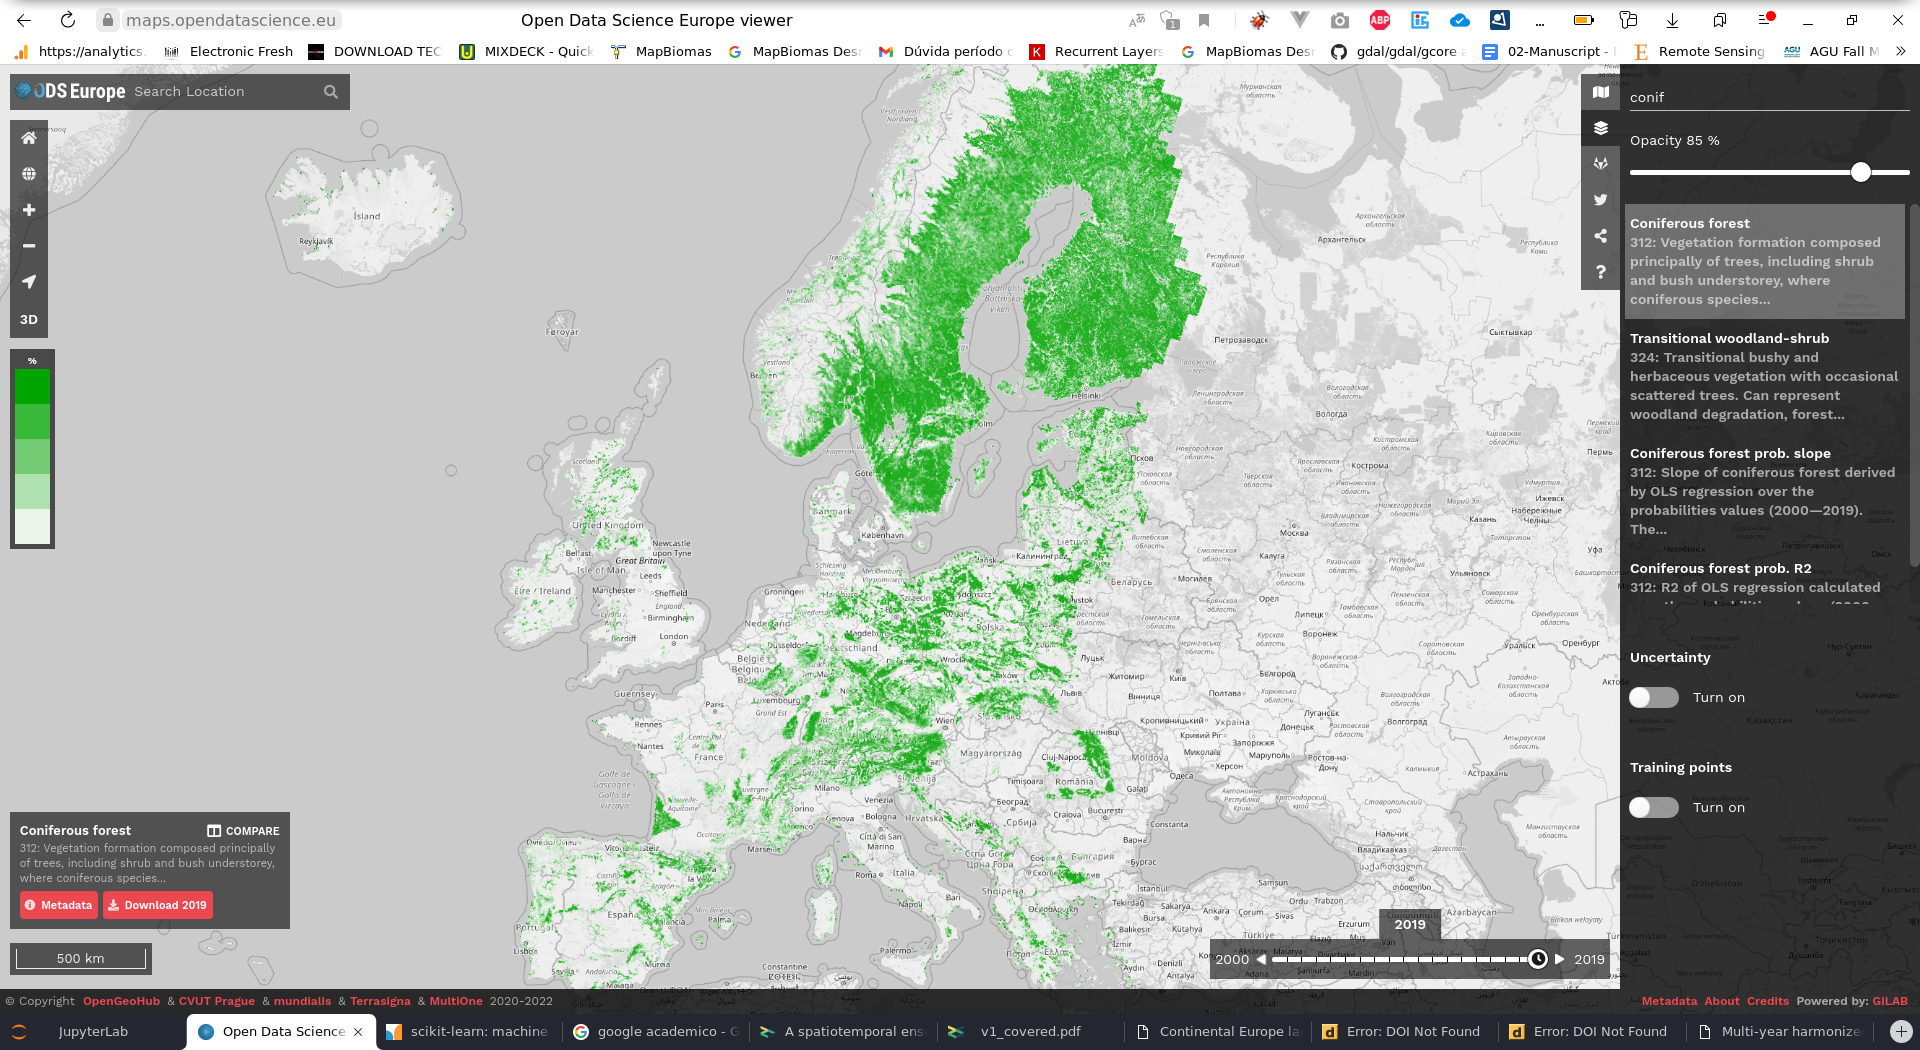

First, let's import some common python modules/libraries

In [1]:
import sys

# To work with local eumap code
# import sys
sys.path.append('/home/opengeohub/leandro/Code/eumap/')

from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from eumap.mapper import LandMapper

import warnings
warnings.filterwarnings('ignore')

and define the data directory:

In [2]:
ODSE_DATA_DIR = Path.home().joinpath('ODSE_workdir').joinpath('data')
TILE_ID = 14580 # The other tile_id available is 5606

raster_dir = ODSE_DATA_DIR.joinpath(f'tile_{TILE_ID}')

print(f'ODSE data dir: {ODSE_DATA_DIR}')
print(f'Raster dir: {raster_dir}')

ODSE data dir: /home/opengeohub/ODSE_workdir/data
Raster dir: /home/opengeohub/ODSE_workdir/data/tile_14580


Next step is read the samples ([GeoPackage](https://www.geopackage.org/https://www.geopackage.org/) format) using [GeoPandas](https://geopandas.org/getting_started.htmlhttps://geopandas.org/getting_started.html):

In [3]:
samples = ODSE_DATA_DIR.joinpath('land_cover_samples.gpkg')
points = gpd.read_file(samples)
points

uid  sample_id  lucas          survey_date  clc_class  confidence  \
0        1    1043933  False  2000-06-30T00:00:00      112.0        85.0   
1        2    1044143  False  2000-06-30T00:00:00      112.0        85.0   
2        3    1045508  False  2000-06-30T00:00:00      142.0        85.0   
3        4    1047826  False  2000-06-30T00:00:00      121.0        85.0   
4        5    1047851  False  2000-06-30T00:00:00      121.0        85.0   
...    ...        ...    ...                  ...        ...         ...   
1986  1987    1969703  False  2018-06-30T00:00:00      324.0        85.0   
1987  1988    1973479  False  2018-06-30T00:00:00      411.0        85.0   
1988  1989    1973669  False  2018-06-30T00:00:00      512.0        85.0   
1989  1990    2229815  False  2018-06-30T00:00:00      242.0        85.0   
1990  1991    2234920  False  2018-06-30T00:00:00      242.0        85.0   

      tile_id  \
0       14580   
1       14580   
2       14580   
3       14580   
4       14580   
...       ...   
1986     5606   
1987     5606   
1988     5606   
1989     5606   
1990     5606   

      dtm_cost.distance.to.coast_gedi.grass.gis_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2  \
0                                                  16.0                                     
1                                                  17.0                                     
2                                                  26.0                                     
3                                                  20.0                                     
4                                                  18.0                                     
...                                                 ...                                     
1986                                               30.0                                     
1987                                                1.0                                     
1988                                               77.0                                     
1989                                               97.0                                     
1990                                               91.0                                     

      dtm_slope.percent_gedi.eml_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2  \
0                                                   3.0                        
1                                                   9.0                        
2                                                   5.0                        
3                                                   2.0                        
4                                                  18.0                        
...                                                 ...                        
1986                                               65.0                        
1987                                                5.0                        
1988                                                5.0                        
1989                                               19.0                        
1990                                               16.0                        

      dtm_hillshade.multid_gedi.gdal_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2  \
0                                                 179.0                            
1                                                 174.0                            
2                                                 184.0                            
3                                                 179.0                            
4                                                 167.0                            
...                                                 ...                            
1986                                              208.0                            
1987                                              184.0                            
1988                                              184.0

Let's explore some of the columns using a [barplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html):

In [4]:
def barplot_counts(dataset, column_name):

    arr_counts = dataset.value_counts(column_name)
    years = arr_counts.index.values
    counts = np.array(arr_counts)
    
    int_x = False
    if isinstance(years[0], np.int64):
        years_all = range(min(years), max(years)+1)
        int_x = True
    else: 
        years_all = years
        
    if len(years) < 5:
        years = [str(item) for item in years]
        years_all = years
        
    fig, ax = plt.subplots(figsize = (10,4))
    ax.bar(x = years, height = counts);
    if int_x:
        ax.set_xticks(years_all);
    ax.set_xticklabels(years_all, rotation=90)
    ax.set_title('Training point count')
    ax.set_xlabel('options');
    ax.set_ylabel('# of training points');

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


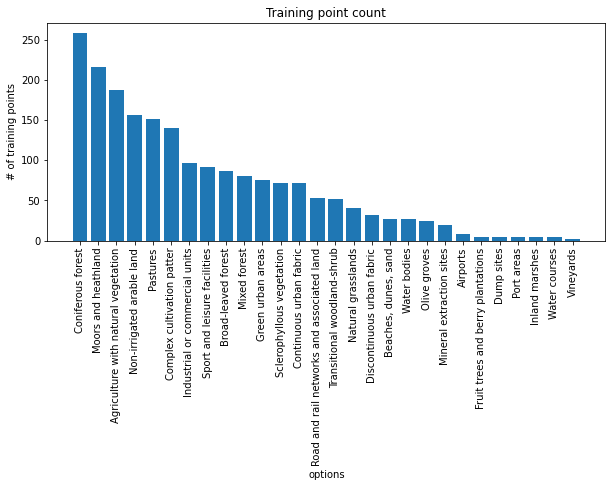

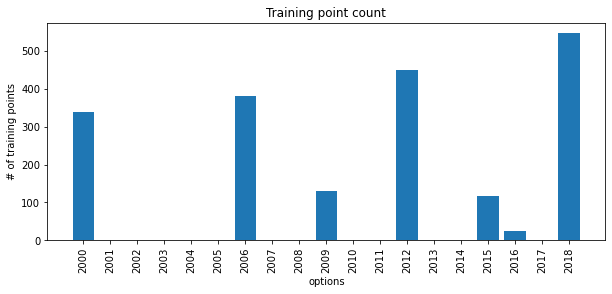

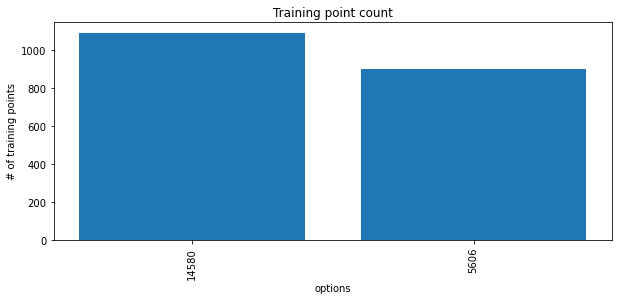

In [5]:
plot_cols = ['clc_class_name', 'survey_year','tile_id',]

for colname in plot_cols:
    barplot_counts(points,colname)

## A regular Random Forest

Random Forest is one of the most popular algorithms used by remote sensing community ([Belgiu & Drăguţ, 2016](https://www.sciencedirect.com/science/article/abs/pii/S0924271616000265)). Duo its versatility, this ML model is able to produce highly accurate predictions over different application domains using little or almost none hyper parameter optimization. Nevertheless, it may not generalize well in [regression problems](https://medium.com/swlh/random-forest-and-its-implementation-71824ced454f), a well know limitation of [decision trees](https://dhirajkumarblog.medium.com/top-5-advantages-and-disadvantages-of-decision-tree-algorithm-428ebd199d9a). Since in the scope of this tutorial you are dealing with a classification problem, Random Forest is a good starting point.

The [LandMapper class](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.mapper.LandMapper.html#eumap.mapper.LandMapper) will receive the training points, the ML model implementation ([all estimator implementation are supporter](https://scikit-learn.org/stable/modules/classes.html)) and the [cross-validation strategy](https://scikit-learn.org/stable/modules/cross_validation.html). Use the parameter ``feat_col_prfxs`` to inform which columns will be considering as covariates/features in the training step. It's important emphasize that for all columns used in the training, you need to have a raster image, otherwise you can not run the spatial prediction. 

For now, let's use only the points for one tile (``TILE_ID``):

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

estimator = RandomForestClassifier(n_estimators=5)
points_tile = points[points['tile_id'] == TILE_ID]
cv = KFold(5)

feat_col_prfxs = [
    'dtm_elev.lowestmode',
    'dtm_cost.distance.to.coast',
    'lcv_blue_landsat.glad.ard_',
    'lcv_green_landsat.glad.ard_',
    'lcv_red_landsat.glad.ard_',
    'lcv_nir_landsat.glad.ard_',
    'lcv_swir1_landsat.glad.ard_',
    'lcv_swir2_landsat.glad.ard_',
    'lcv_thermal_landsat.glad.ard_',
] # add prefixes for spacetime variables!

target_col = 'clc_class'

landmapper = LandMapper(points=points_tile,
                        feat_col_prfxs = feat_col_prfxs,
                        target_col = target_col,
                        estimator = estimator,
                        cv=cv,
                        min_samples_per_class=0.05,
                        verbose = True)

[22:54:40] Removing 302 samples (clc_class in [112. 122. 123. 124. 141. 242. 243. 222. 321. 331. 512. 111. 511. 131.]) due min_samples_per_class condition (< 0.05)
[22:54:40] Transforming clc_class:
[22:54:40]  -Original classes: [121. 142. 211. 231. 311. 312. 313. 322.]
[22:54:40]  -Transformed classes: [0 1 2 3 4 5 6 7]


Note that samples with less than 5% representativeness in total have been removed, and the land cover values were converted to sequential numbers.

Now it's time to run the training. Don't forget to set the ``seed`` to get reproducibility for the entire approach. 

In [7]:
np.random.seed(1989)
landmapper.train()

[22:54:40] Calculating evaluation metrics
[22:54:40] Training RandomForestClassifier using all samples


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


After the training, you can access a classification report. 

In the context of land cover classification, the precision was renamed to Producer's Accuracy (the producer of the classification is interested in understand how well a specific area on Earth can be mapped) and the recall was renamed to User's Accuracy (the user of classification is interested in check how well the map represents what is really on the ground) ([Story, 1986](https://www.asprs.org/wp-content/uploads/pers/1986journal/mar/1986_mar_397-399.pdf)). The [F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) is a combination of this booth metrics. 

In [8]:
print(f'Overall accuracy: {landmapper.eval_metrics["overall_acc"] * 100:.2f}%\n\n')
print(landmapper.eval_report)

Overall accuracy: 56.58%


              precision    recall  f1-score   support

           0       0.57      0.52      0.54        64
           1       0.31      0.41      0.35        76
           2       0.62      0.65      0.64       139
           3       0.72      0.72      0.72       144
           4       0.51      0.55      0.53        80
           5       0.48      0.48      0.48        92
           6       0.24      0.17      0.20        72
           7       0.77      0.72      0.74       123

    accuracy                           0.57       790
   macro avg       0.53      0.53      0.53       790
weighted avg       0.57      0.57      0.56       790



It's possible also analyze the confusion matrix:

Verifing the label order:
 - 0 => 121: Industrial or commercial units
 - 1 => 312: Coniferous forest
 - 2 => 142: Sport and leisure facilities
 - 3 => 231: Pastures
 - 4 => 211: Non-irrigated arable land
 - 5 => 313: Mixed forest
 - 6 => 322: Moors and heathland
 - 7 => 311: Broad-leaved forest


Confusion Matrix:


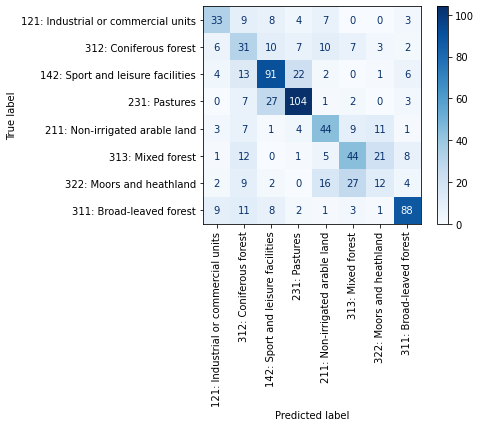

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

# create dictionary for matching class codes to descriptions for plotting
clc_classes_list = points['clc_class'].unique()
clc_class_name_dict = {int(clc_class): points[points['clc_class'] == clc_class]['clc_class_name'].reset_index(drop=True)[0] for clc_class in clc_classes_list}

# create labels dict
labels = {f'{int(value)}: {clc_class_name_dict[value]}' for value in landmapper.target_classes['original']}

estimator = landmapper.estimator_list[0]
print("Verifing the label order:")
for label, cl in zip(labels, estimator.classes_):
    print(f' - {cl:.0f} => {label}')

print("\n\nConfusion Matrix:")
confusion_matrix = landmapper.eval_metrics['confusion_matrix']
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
disp.plot(cmap='Blues', xticks_rotation='vertical');

The target and predicted values, calculated by the cross validation and used to derive these metrics are also available:

In [10]:
pd.DataFrame({
    'Expected LC-class':landmapper.target,
    'Predict LC-class': landmapper.eval_pred}
)

Expected LC-class  Predict LC-class
0                    1                 1
1                    0                 0
2                    0                 3
3                    0                 0
4                    0                 0
..                 ...               ...
785                  7                 7
786                  6                 5
787                  1                 1
788                  6                 5
789                  6                 5

[790 rows x 2 columns]

After training, you can save the model to load later:

In [11]:
fn_joblib = raster_dir.joinpath('landmapper_rf.lz4')
landmapper.save_instance(fn_joblib)
fn_joblib

PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/landmapper_rf.lz4')

To demonstrate how to load the a LandMapper instance, let's restart the restart the kernel:

In [ ]:
import os
os._exit(00) # resets the kernel

You need to load again the main modules/libraries

In [1]:
import sys

from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from eumap.mapper import LandMapper

import warnings
warnings.filterwarnings('ignore')

... define the data directory and load the points:

In [2]:
ODSE_DATA_DIR = Path.home().joinpath('ODSE_workdir').joinpath('data')
TILE_ID = 14580 # The other tile_id available is 5606

raster_dir = ODSE_DATA_DIR.joinpath(f'tile_{TILE_ID}')

print(f'ODSE data dir: {ODSE_DATA_DIR}')
print(f'Raster dir: {raster_dir}')

ODSE data dir: /home/opengeohub/ODSE_workdir/data
Raster dir: /home/opengeohub/ODSE_workdir/data/tile_14580


In [3]:
samples = ODSE_DATA_DIR.joinpath('land_cover_samples.gpkg')
points = gpd.read_file(samples)

clc_classes_list = points['clc_class'].unique()
clc_class_name_dict = {int(clc_class): points[points['clc_class'] == clc_class]['clc_class_name'].reset_index(drop=True)[0] for clc_class in clc_classes_list}

Call the [static method](https://www.pythontutorial.net/python-oop/python-static-methods/) ``load_instance`` to load a pre-trained LandMapper:

In [4]:
landmapper = LandMapper.load_instance(raster_dir.joinpath('landmapper_rf.lz4'))

Now you are ready execute a spatial prediction, but first it's necessary prepare the raster files as input.

Let's start with the timeless layers:

In [5]:
from eumap.misc import find_files

timeless_rasters = []

for name in landmapper.feature_cols:
    raster_files = find_files(raster_dir, f'{name}*')
    if len(raster_files):
        timeless_rasters += raster_files

timeless_rasters

[PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/dtm/dtm_elev.lowestmode_gedi.eml_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/dtm/dtm_cost.distance.to.coast_gedi.grass.gis_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2.tif')]

For the temporal layers you retrieve all the Landsat data of 2018:

In [6]:
from eumap.misc import find_files

temporal_rasters = []
year = 2018

for prf in landmapper.feat_col_prfxs:
    if 'lcv' in prf:
        temporal_rasters += find_files(raster_dir, f'{prf}*..{year}*')

print(f'5/{len(temporal_rasters)} files')
temporal_rasters[0:5]

5/84 files


[PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2017.12.02..2018.03.20_eumap_epsg3035_v1.1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2018.03.21..2018.06.24_eumap_epsg3035_v1.1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2018.06.25..2018.09.12_eumap_epsg3035_v1.1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2018.09.13..2018.12.01_eumap_epsg3035_v1.1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_blue_landsat.glad.ard_p50_30m_0..0cm_2017.12.02..2018.03.20_eumap_epsg3035_v1.1.tif')]

The prediction input is the combination of these two groups of layers:

In [7]:
fn_layers = timeless_rasters.extend(temporal_rasters)
fn_layers = timeless_rasters

However, LandMappper needs to match the rasters with the column names used during the training. To allow it you can pass a ``dict_layers_newnames``, where the key is the column name and the value is the current raster name. Here we present a custom function, specific for the [ODSE file naming convention](https://gitlab.com/geoharmonizer_inea/spatial-layers#file-naming-convention), responsible to identify and remove the year from the file name.

In [8]:
def _dict_layers_newnames(temporal_rasters): 
    result = {}
    
    for tr in temporal_rasters:
        filename = tr.stem
        newname = filename.replace(str(year),'') \
                          .replace(str(year-1),'')
        result[newname] = filename
        
    return  result
    
dict_layers_newnames = _dict_layers_newnames(temporal_rasters)

After define the output file, you can run the prediction: 

In [9]:
fn_output = raster_dir.joinpath(f'lcv_land.cover_rf_{year}_{TILE_ID}.tif')

output_fn_files = landmapper.predict(fn_layers=fn_layers, 
                                     fn_output=fn_output, 
                                     dict_layers_newnames = dict_layers_newnames, 
                                     verbose_renaming=False)

[22:58:50] Reading 86 raster files using 4 workers
[22:58:56] Executing RandomForestClassifier
[22:58:57] RandomForestClassifier prediction time: 0.63 segs


You can have a quick preview using [eumap.plotter](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.plotter.plot_rasters.html#eumap.plotter.plot_rasters), however it's better use QGIS to analyze the result: 

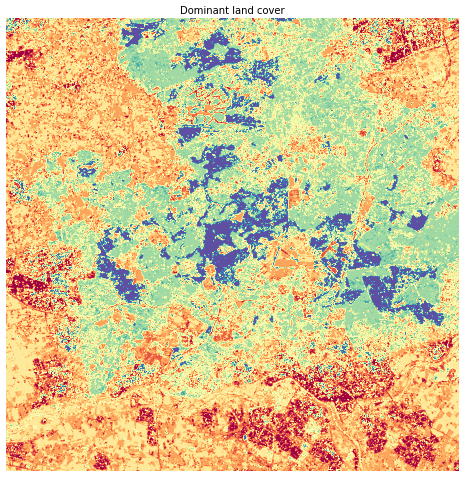

In [10]:
from eumap.plotter import plot_rasters
plot_rasters(output_fn_files[0], titles = 'Dominant land cover', dpi = 60)

## Random Forest with hyperparameter optimization

LandMapper can be used with a [BaseSearchCV](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) implementation to find the best hyperparamenter for the specified model. For the hyperparameter optimization it's possible to select different [scoring metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and hyperparameter range values. Here you will use the [F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) a few RandomForest hyperparameters:

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

estimator = RandomForestClassifier(n_estimators=5)
points_tile = points[points['tile_id'] == TILE_ID]
cv = KFold(5)

feat_col_prfxs = [
    'dtm_elev.lowestmode',
    'dtm_cost.distance.to.coast',
    'lcv_blue_landsat.glad.ard_',
    'lcv_green_landsat.glad.ard_',
    'lcv_red_landsat.glad.ard_',
    'lcv_nir_landsat.glad.ard_',
    'lcv_swir1_landsat.glad.ard_',
    'lcv_swir2_landsat.glad.ard_',
    'lcv_thermal_landsat.glad.ard_',
] # add prefixes for spacetime variables!

target_col = 'clc_class'

# hyperparameter optimization
hyperpar = GridSearchCV(
    estimator = estimator,
    scoring = 'f1_weighted',
    cv = cv,
    verbose= True,
    param_grid = {
     'max_depth': [5, 10, None],
     'max_features': [0.5, None],
     'n_estimators': [5, 20, 40]
    }
)

Let’s optimize and train the model:

In [12]:
landmapper = LandMapper(points=points_tile,
                        feat_col_prfxs = feat_col_prfxs,
                        target_col = target_col,
                        estimator = estimator,
                        hyperpar_selection = hyperpar,
                        cv = cv,
                        cv_njobs = 2,
                        min_samples_per_class=0.05,
                        verbose = True)

[22:58:57] Removing 302 samples (clc_class in [112. 122. 123. 124. 141. 242. 243. 222. 321. 331. 512. 111. 511. 131.]) due min_samples_per_class condition (< 0.05)
[22:58:57] Transforming clc_class:
[22:58:57]  -Original classes: [121. 142. 211. 231. 311. 312. 313. 322.]
[22:58:57]  -Transformed classes: [0 1 2 3 4 5 6 7]


In [13]:
np.random.seed(1989)
landmapper.train()

[22:58:57] Optimizing hyperparameters for RandomForestClassifier
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[22:59:06]  -0.56660 (+/-0.06146) from {'max_depth': 5, 'max_features': 0.5, 'n_estimators': 5}
[22:59:06]  -0.60817 (+/-0.05092) from {'max_depth': 5, 'max_features': 0.5, 'n_estimators': 20}
[22:59:06]  -0.60115 (+/-0.06882) from {'max_depth': 5, 'max_features': 0.5, 'n_estimators': 40}
[22:59:06]  -0.58430 (+/-0.07089) from {'max_depth': 5, 'max_features': None, 'n_estimators': 5}
[22:59:06]  -0.60498 (+/-0.03166) from {'max_depth': 5, 'max_features': None, 'n_estimators': 20}
[22:59:06]  -0.61317 (+/-0.03279) from {'max_depth': 5, 'max_features': None, 'n_estimators': 40}
[22:59:06]  -0.58932 (+/-0.04357) from {'max_depth': 10, 'max_features': 0.5, 'n_estimators': 5}
[22:59:06]  -0.60720 (+/-0.05761) from {'max_depth': 10, 'max_features': 0.5, 'n_estimators': 20}
[22:59:06]  -0.63735 (+/-0.05920) from {'max_depth': 10, 'max_features': 0.5, 'n_estimators': 40

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[22:59:07] Training RandomForestClassifier using all samples


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.1s finished


Let's understand what happened here:
1. Diferent combinations of hyperparameters were evaluated
2. The best one was chosen and all the samples were cross validated to derive other classification metrics
3. A final model were trained using all the samples, without cv. This model will used for spatial prediction

You can check other classification metrics for the best classification models

In [14]:
print(f'Overall accuracy: {landmapper.eval_metrics["overall_acc"] * 100:.2f}%\n\n')
print(landmapper.eval_report)

Overall accuracy: 63.42%


              precision    recall  f1-score   support

           0       0.77      0.58      0.66        64
           1       0.49      0.42      0.45        76
           2       0.70      0.73      0.72       139
           3       0.73      0.78      0.76       144
           4       0.42      0.45      0.44        80
           5       0.55      0.61      0.58        92
           6       0.36      0.28      0.31        72
           7       0.78      0.85      0.82       123

    accuracy                           0.63       790
   macro avg       0.60      0.59      0.59       790
weighted avg       0.63      0.63      0.63       790



… and the complete confusion matrix:

Verifing the label order:
 - 0 => 121: Industrial or commercial units
 - 1 => 211: Non-irrigated arable land
 - 2 => 312: Coniferous forest
 - 3 => 231: Pastures
 - 4 => 142: Sport and leisure facilities
 - 5 => 313: Mixed forest
 - 6 => 322: Moors and heathland
 - 7 => 311: Broad-leaved forest


Confusion Matrix:


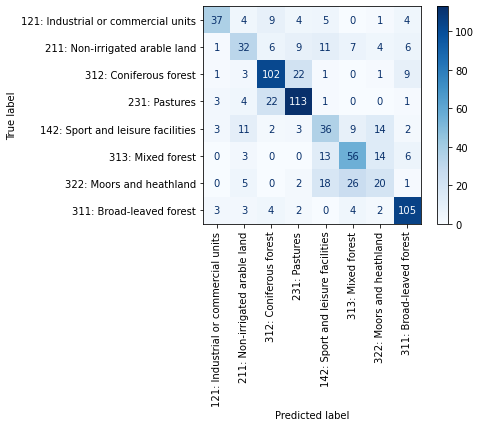

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

# create dictionary for matching class codes to descriptions for plotting
clc_classes_list = points['clc_class'].unique()
clc_class_name_dict = {int(clc_class): points[points['clc_class'] == clc_class]['clc_class_name'].reset_index(drop=True)[0] for clc_class in clc_classes_list}

# create labels dict
labels = {f'{int(value)}: {clc_class_name_dict[value]}' for value in landmapper.target_classes['original']}

estimator = landmapper.estimator_list[0]
print("Verifing the label order:")
for label, cl in zip(labels, estimator.classes_):
    print(f' - {cl:.0f} => {label}')

print("\n\nConfusion Matrix:")
confusion_matrix = landmapper.eval_metrics['confusion_matrix']
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
disp.plot(cmap='Blues', xticks_rotation='vertical');

In [16]:
fn_joblib = raster_dir.joinpath('landmapper_rf.lz4')
landmapper.save_instance(fn_joblib)
fn_joblib

PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/landmapper_rf.lz4')

## Random Forest with probabilities and hyperparameter optimization

Random Forest [supports probability outputs](https://www.linkedin.com/pulse/decoding-probabilities-random-forest-sanchit-tiwari/), derive by the number of votes from the trained decision trees in each class. For this type of output, it's recommended a different evaluation metric for the the hyperparameter optimization, as for example the [log_loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) (logistic loss or cross-entropy loss).

Unlike the F1-Score, a lower log_loss is better for the optimization process, and because of that it's necessary multiply returned error by -1.

In [17]:
from sklearn.metrics import log_loss

def log_loss_scorer(clf, X, y_true):
    class_labels = clf.classes_
    y_pred_proba = clf.predict_proba(X)
    error = log_loss(y_true, y_pred_proba, labels=class_labels)
    return error * -1


You will keep all the parameters the same, changing only the ``scoring`` of ``GridSearchCV``

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

estimator = RandomForestClassifier(n_estimators=5)
points_tile = points[points['tile_id'] == TILE_ID]
cv = KFold(5)

feat_col_prfxs = [
    'dtm_elev.lowestmode',
    'dtm_cost.distance.to.coast',
    'lcv_blue_landsat.glad.ard_',
    'lcv_green_landsat.glad.ard_',
    'lcv_red_landsat.glad.ard_',
    'lcv_nir_landsat.glad.ard_',
    'lcv_swir1_landsat.glad.ard_',
    'lcv_swir2_landsat.glad.ard_',
    'lcv_thermal_landsat.glad.ard_',
] # add prefixes for spacetime variables!

target_col = 'clc_class'

# hyperparameter optimization
hyperpar = GridSearchCV(
    estimator = estimator,
    scoring = log_loss_scorer,
    cv = cv,
    verbose= True,
    param_grid = {
     'max_depth': [5, 10, None],
     'max_features': [0.5, None],
     'n_estimators': [5, 20, 40]
    }
)

... and sending ``predict_proba`` to LandMapper:

In [19]:
landmapper = LandMapper(points=points_tile,
                        feat_col_prfxs = feat_col_prfxs,
                        target_col = target_col,
                        estimator = estimator,
                        hyperpar_selection = hyperpar,
                        pred_method='predict_proba',
                        min_samples_per_class=0.05,
                        cv = cv,
                        cv_njobs = 2,
                        verbose = True)

[22:59:09] Removing 302 samples (clc_class in [112. 122. 123. 124. 141. 242. 243. 222. 321. 331. 512. 111. 511. 131.]) due min_samples_per_class condition (< 0.05)
[22:59:09] Transforming clc_class:
[22:59:09]  -Original classes: [121. 142. 211. 231. 311. 312. 313. 322.]
[22:59:09]  -Transformed classes: [0 1 2 3 4 5 6 7]


Let's run:

In [20]:
np.random.seed(1989)
landmapper.train()

[22:59:09] Optimizing hyperparameters for RandomForestClassifier
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[22:59:21]  1.29548 (+/-0.41592) from {'max_depth': 5, 'max_features': 0.5, 'n_estimators': 5}
[22:59:21]  1.14599 (+/-0.20099) from {'max_depth': 5, 'max_features': 0.5, 'n_estimators': 20}
[22:59:21]  1.11304 (+/-0.06912) from {'max_depth': 5, 'max_features': 0.5, 'n_estimators': 40}
[22:59:21]  1.56764 (+/-0.64675) from {'max_depth': 5, 'max_features': None, 'n_estimators': 5}
[22:59:21]  1.13402 (+/-0.06025) from {'max_depth': 5, 'max_features': None, 'n_estimators': 20}
[22:59:21]  1.14020 (+/-0.16961) from {'max_depth': 5, 'max_features': None, 'n_estimators': 40}
[22:59:21]  5.25577 (+/-3.00405) from {'max_depth': 10, 'max_features': 0.5, 'n_estimators': 5}
[22:59:21]  1.51316 (+/-0.41363) from {'max_depth': 10, 'max_features': 0.5, 'n_estimators': 20}
[22:59:21]  1.10916 (+/-0.31005) from {'max_depth': 10, 'max_features': 0.5, 'n_estimators': 40}
[22:59:

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[22:59:22] Training RandomForestClassifier using all samples


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.1s finished


The classification report for a probability output is different:

In [21]:
print(f'Log loss: {landmapper.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper.eval_report)

Log loss: 1.217


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  1.5925     0.7009   0.2340        0.5938              0.5938         64
1  1.5259     0.4746   0.2627        0.4868              0.4933         76
2  1.1112     0.7341   0.3608        0.6835              0.6835         139
3  0.9126     0.8202   0.4110        0.7569              0.7569         144
4  1.8161     0.4489   0.3250        0.5000              0.5000         80
5  1.1014     0.6271   0.3624        0.5978              0.5978         92
6  1.4057     0.3954   0.3209        0.4167              0.4167         72
7  0.8905     0.8863   0.3562        0.8211              0.8211         123

Total                                                                     790



Let's understand this report.

Using the cv result, the LandMapper calculated the **log_loss** and the **[pr_auc (area under the precision recall curve)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve)** for each class. The pr_auc information was used to choose the **best probability** value to derive a hard classification output, balancing the **precision** (*producer's accuracy or the class understimation*) and **recall** (*user's accuracy or the class overestimation*), thus minimizing the bias in the land cover area estimation. For more infomation about the precision recall curve [access this link](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/).

All the probabilities metrics are available through the prob_metrics property

In [22]:
list(landmapper.prob_metrics.keys())

['log_loss',
 'pr_auc',
 'support',
 'opti_th',
 'opti_recall',
 'opti_precision',
 'curv_recall',
 'curv_precision',
 'curv_th']

…and it’s possible to use the raw cv results to derive other evaluation metrics as [hinge_loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html):

In [23]:
from sklearn import preprocessing, metrics

# Tranform the target classes in probability values
lb = preprocessing.LabelBinarizer()
targ_prob = lb.fit_transform(landmapper.target)
n_classes = len(lb.classes_)

# Brier loss calculation for each class
print('Brier loss:')
for c in range(0,n_classes):
    brier_loss = metrics.brier_score_loss(targ_prob[:,c], landmapper.eval_pred[:,c])
    print(f' - {lb.classes_[c]:.0f}: {brier_loss * 100:.3f}%')

Brier loss:
 - 0: 3.957%
 - 1: 6.749%
 - 2: 7.984%
 - 3: 6.453%
 - 4: 7.028%
 - 5: 6.317%
 - 6: 6.607%
 - 7: 4.538%


Now let's make a prediction and generate probability values for each class.

First you need to organize the all input rasters:

In [24]:
from eumap.misc import find_files

timeless_rasters = []

for name in landmapper.feature_cols:
    raster_files = find_files(raster_dir, f'{name}*')
    if len(raster_files):
        timeless_rasters += raster_files


from eumap.misc import find_files

temporal_rasters = []
year = 2018

for prf in feat_col_prfxs:
    if 'lcv' in prf:
        temporal_rasters += find_files(raster_dir, f'{prf}*..{year}*')

fn_layers = timeless_rasters.extend(temporal_rasters)
fn_layers = timeless_rasters

def _dict_layers_newnames(temporal_rasters): 
    result = {}
    
    for tr in temporal_rasters:
        filename = tr.stem
        newname = filename.replace(str(year),'') \
                          .replace(str(year-1),'')
        result[newname] = filename
        
    return  result
    
dict_layers_newnames = _dict_layers_newnames(temporal_rasters)

Then we can use the landmapper class to make the predictions, now we get multiple outputs: 

In [25]:
fn_output = raster_dir.joinpath(f'lcv_land.cover_rf.prob_{year}_{TILE_ID}.tif')

output_fn_files = landmapper.predict(fn_layers=fn_layers, 
                                     fn_output=fn_output, 
                                     dict_layers_newnames = dict_layers_newnames, 
                                     verbose_renaming=False,
                                     allow_additional_layers=True)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {output_fn_file}')

[22:59:23] Reading 86 raster files using 4 workers
[22:59:30] Executing RandomForestClassifier
[22:59:34] RandomForestClassifier prediction time: 4.20 segs
Output files:
 - /home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_b1.tif
 - /home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_b2.tif
 - /home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_b3.tif
 - /home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_b4.tif
 - /home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_b5.tif
 - /home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_b6.tif
 - /home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_b7.tif
 - /home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_b8.tif
 - /home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_hcl.tif
 - /home/opengeohub

You can plot the dominant land cover:

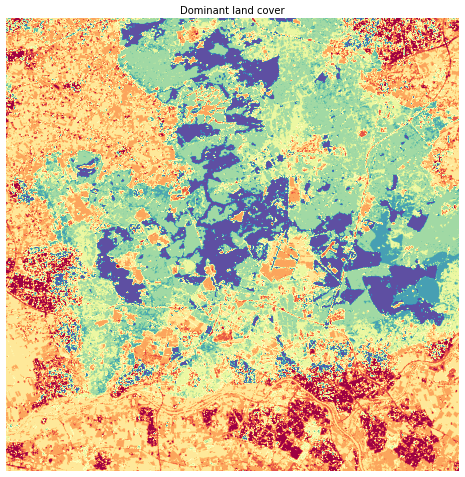

In [26]:
from eumap.plotter import plot_rasters
import numpy as np
from matplotlib.colors import ListedColormap

lc_classes = landmapper.target_classes['original']
pixel_values = landmapper.target_classes['transformed']

plot_rasters(output_fn_files[8], titles = 'Dominant land cover', dpi = 60)

Now you can also plot the probabilities for each class and get some information about where the model is quite certain and where it is not: 

Verifing the label order:
 - 0 => 121: Industrial or commercial units
 - 1 => 211: Non-irrigated arable land
 - 2 => 312: Coniferous forest
 - 3 => 231: Pastures
 - 4 => 142: Sport and leisure facilities
 - 5 => 313: Mixed forest
 - 6 => 322: Moors and heathland
 - 7 => 311: Broad-leaved forest


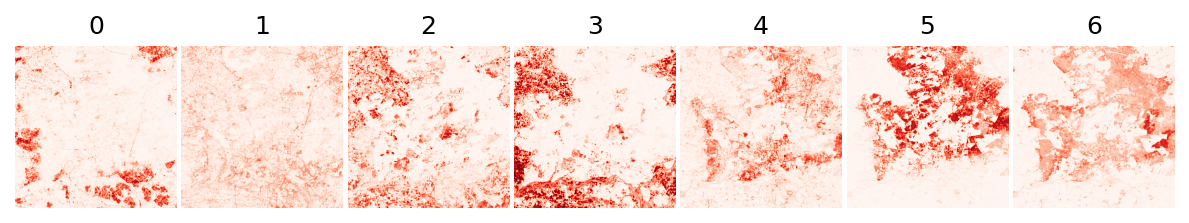

In [27]:
import numpy as np
from eumap.plotter import plot_rasters

estimator = landmapper.estimator_list[0]
print("Verifing the label order:")
for label, cl in zip(labels, estimator.classes_):
    print(f' - {cl:.0f} => {label}')

lc_classes = [ int(c) for c in landmapper.target_classes['transformed']]

plot_rasters(*output_fn_files[0:7], cmaps='Reds', titles=lc_classes , vertical_layout=False)

## EML with probabilities, uncertainty and hyperparameter optimization

Primarily, ensemble machine learning is a technique to combine multiple models/learners to improve the classification/regression performance compared with a single model. Random Forest is already a EML, because combines multiple decision trees, however you can combine multiple ensemble models in [different ways (see mlens)](http://ml-ensemble.com/info/tutorials/start.html). 

In this section you will modify the LandMapper to execute the follow EML pipeline, combining multiple models with hyperparameter optimization and producing this time dominant land cover classes, probabilities and uncertainties:

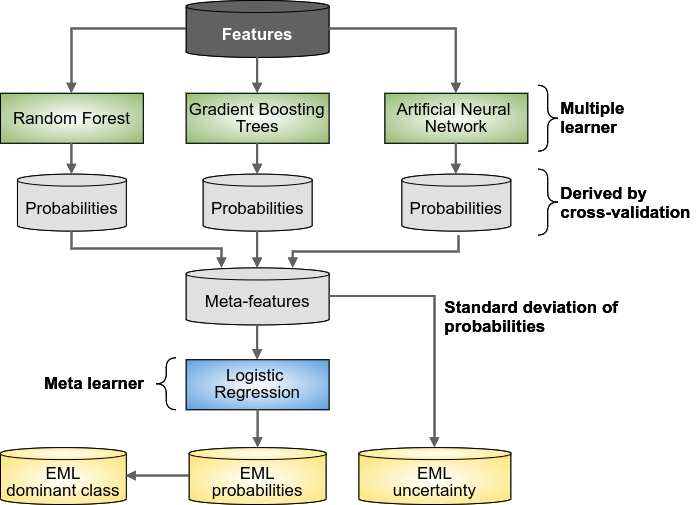

It is important to keep the same hiperparameters for the Random Forest:

In [28]:
from sklearn.ensemble import RandomForestClassifier

estimator_rf = RandomForestClassifier(n_jobs=-1)

hyperpar_rf = GridSearchCV(
    estimator = estimator_rf,
    scoring = log_loss_scorer,
    param_grid = {
     'max_depth': [5, 10, None],
     'max_features': [0.5, None],
     'n_estimators': [5, 20, 40]
    }
)

Our second model will be a Gradient Boosting Trees implemented by [XGBoost](https://xgboost.readthedocs.io/en/latest/).

In [29]:
import xgboost as xgb
estimator_bgtree = xgb.XGBClassifier(n_jobs=-1, n_estimators=28, objective='multi:softmax', 
                                     use_label_encoder=False, eval_metric='mlogloss', booster='gbtree')

hyperpar_bgtree = GridSearchCV(
    estimator = estimator_bgtree,
    scoring = log_loss_scorer,
    
    param_grid = {
     'eta': [0.001, 0.9], 
     'alpha': [0, 10]
    }
)

The third learner will be a pretty standard regular neural network ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) and [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers) implemented in [Tensorflow](https://www.tensorflow.org/) and available in [eumap](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.mapper.build_ann.html#eumap.mapper.build_ann):

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from eumap.mapper import build_ann

input_shape = 87
n_classes = 8
estimator_ann = Pipeline([
    ('standardize', StandardScaler()),
    ('estimator', KerasClassifier(build_ann, input_shape=input_shape, output_shape=n_classes, \
        epochs=5, batch_size=64, learning_rate = 0.0005, \
        dropout_rate=0.15, n_layers = 4, n_neurons=32, shuffle=True, verbose=False))
])

hyperpar_ann = GridSearchCV(
    estimator = estimator_ann,
    scoring = log_loss_scorer,
    param_grid = {
     'estimator__dropout_rate': [0, 0.15], 
     'estimator__n_layers': [2, 4]
    }
)

As meta-learner we will use [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html):

In [31]:
from sklearn.linear_model import LogisticRegression

meta_estimator = LogisticRegression(solver='saga', multi_class='multinomial')

hyperpar_meta = GridSearchCV(
    estimator = meta_estimator,
    scoring = log_loss_scorer,
    param_grid = {
        'fit_intercept': [False, True],
        'C': [0.5, 1]
    }
)

Now, let's send the learners and respective GridSearchCV objects to the LandMapper. The ``pred_method='predict_proba'`` is not necessary anymore, because LandMapper will infer it by the parameter ``estimator_list``:

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

points_tile = points[points['tile_id'] == TILE_ID]
cv = KFold(5)

feat_col_prfxs = [
    'dtm_elev.lowestmode',
    'dtm_cost.distance.to.coast',
    'lcv_blue_landsat.glad.ard_',
    'lcv_green_landsat.glad.ard_',
    'lcv_red_landsat.glad.ard_',
    'lcv_nir_landsat.glad.ard_',
    'lcv_swir1_landsat.glad.ard_',
    'lcv_swir2_landsat.glad.ard_',
    'lcv_thermal_landsat.glad.ard_',
] # add prefixes for spacetime variables!

target_col = 'clc_class'

estimator_list = [estimator_rf, estimator_bgtree, estimator_ann]
hyperpar_selection_list = [hyperpar_rf, hyperpar_bgtree, hyperpar_ann]

landmapper = LandMapper(points=points_tile,
                        feat_col_prfxs = feat_col_prfxs,
                        target_col = target_col,
                        estimator_list = estimator_list, 
                        meta_estimator = meta_estimator,
                        hyperpar_selection_list = hyperpar_selection_list,
                        hyperpar_selection_meta = hyperpar_meta,
                        min_samples_per_class=0.05,
                        cv = cv,
                        cv_njobs = 2,
                        verbose = True)

[22:59:36] Removing 302 samples (clc_class in [112. 122. 123. 124. 141. 242. 243. 222. 321. 331. 512. 111. 511. 131.]) due min_samples_per_class condition (< 0.05)
[22:59:36] Transforming clc_class:
[22:59:36]  -Original classes: [121. 142. 211. 231. 311. 312. 313. 322.]
[22:59:36]  -Transformed classes: [0 1 2 3 4 5 6 7]


Let's train

In [33]:
np.random.seed(1989)
landmapper.train()

[22:59:36] Optimizing hyperparameters for RandomForestClassifier
[22:59:46]  1.33079 (+/-0.34951) from {'max_depth': 5, 'max_features': 0.5, 'n_estimators': 5}
[22:59:46]  1.15924 (+/-0.16826) from {'max_depth': 5, 'max_features': 0.5, 'n_estimators': 20}
[22:59:46]  1.11094 (+/-0.10486) from {'max_depth': 5, 'max_features': 0.5, 'n_estimators': 40}
[22:59:46]  1.46727 (+/-0.51677) from {'max_depth': 5, 'max_features': None, 'n_estimators': 5}
[22:59:46]  1.11652 (+/-0.11514) from {'max_depth': 5, 'max_features': None, 'n_estimators': 20}
[22:59:46]  1.14859 (+/-0.17861) from {'max_depth': 5, 'max_features': None, 'n_estimators': 40}
[22:59:46]  4.77338 (+/-0.76714) from {'max_depth': 10, 'max_features': 0.5, 'n_estimators': 5}
[22:59:46]  1.80221 (+/-1.37273) from {'max_depth': 10, 'max_features': 0.5, 'n_estimators': 20}
[22:59:46]  1.21214 (+/-0.31564) from {'max_depth': 10, 'max_features': 0.5, 'n_estimators': 40}
[22:59:46]  4.98451 (+/-1.83983) from {'max_depth': 10, 'max_feature

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[23:00:39]  Meta-features shape: (790, 24)
[23:00:39] Optimizing hyperparameters for LogisticRegression


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    5.4s finished


[23:00:39]  1.04646 (+/-0.20656) from {'C': 0.5, 'fit_intercept': False}
[23:00:39]  1.04960 (+/-0.21558) from {'C': 0.5, 'fit_intercept': True}
[23:00:39]  1.03760 (+/-0.23319) from {'C': 1, 'fit_intercept': False}
[23:00:39]  1.03982 (+/-0.23905) from {'C': 1, 'fit_intercept': True}
[23:00:39] Best: -1.03760 using {'C': 1, 'fit_intercept': False}
[23:00:39] Calculating evaluation metrics
[23:00:39] Training RandomForestClassifier using all samples


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.1s finished


[23:00:40] Training XGBClassifier using all samples
[23:00:40] Training Pipeline using all samples
[23:00:42] Training meta-estimator using all samples


and compare the results:

In [34]:
print(f'Log loss: {landmapper.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper.eval_report)

Log loss: 1.038


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  1.2988     0.6302   0.1437        0.6250              0.6250         64
1  1.3838     0.5942   0.2107        0.6447              0.6447         76
2  0.8841     0.7599   0.4310        0.7194              0.7194         139
3  0.5628     0.8181   0.4181        0.7917              0.7917         144
4  1.5443     0.3878   0.2992        0.4500              0.4500         80
5  1.2140     0.5094   0.3958        0.5543              0.5543         92
6  1.5564     0.2986   0.2901        0.3333              0.3333         72
7  0.6519     0.8600   0.3041        0.8130              0.8130         123

Total                                                                     790



Now you are ready to the generate the predictions

In [35]:
from eumap.misc import find_files

timeless_rasters = []

for name in landmapper.feature_cols:
    raster_files = find_files(raster_dir, f'{name}*')
    if len(raster_files):
        timeless_rasters += raster_files


from eumap.misc import find_files

temporal_rasters = []
year = 2018

for prf in feat_col_prfxs:
    if 'lcv' in prf:
        temporal_rasters += find_files(raster_dir, f'{prf}*..{year}*')

fn_layers = timeless_rasters.extend(temporal_rasters)
fn_layers = timeless_rasters

def _dict_layers_newnames(temporal_rasters): 
    result = {}
    
    for tr in temporal_rasters:
        filename = tr.stem
        newname = filename.replace(str(year),'') \
                          .replace(str(year-1),'')
        result[newname] = filename
        
    return  result
    
dict_layers_newnames = _dict_layers_newnames(temporal_rasters)

In [36]:
fn_output = raster_dir.joinpath(f'lcv_land.cover_eml_{year}_{TILE_ID}.tif')

output_fn_files = landmapper.predict(fn_layers=fn_layers, 
                                     fn_output=fn_output, 
                                     dict_layers_newnames = dict_layers_newnames, 
                                     verbose_renaming=False,
                                     allow_additional_layers=True)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {output_fn_file}')

[23:00:43] Reading 86 raster files using 4 workers
[23:00:50] Executing RandomForestClassifier
[23:00:52] RandomForestClassifier prediction time: 1.76 segs
[23:00:52] Executing XGBClassifier
[23:00:53] XGBClassifier prediction time: 0.85 segs
[23:00:53] Executing Pipeline
[23:00:53] batch_size=500000
[23:01:19] Pipeline prediction time: 26.59 segs
[23:01:19] Executing LogisticRegression
[23:01:22] LogisticRegression prediction time: 2.23 segs
Output files:
 - /home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_eml_2018_14580_b1.tif
 - /home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_eml_2018_14580_b2.tif
 - /home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_eml_2018_14580_b3.tif
 - /home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_eml_2018_14580_b4.tif
 - /home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_eml_2018_14580_b5.tif
 - /home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_eml_2018_14580_b6.tif
 - /home/opengeohub/ODS

Let's check the dominant classes

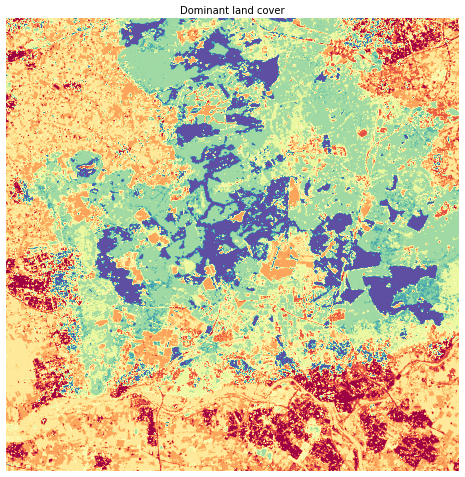

In [37]:
from eumap.plotter import plot_rasters
import numpy as np
from matplotlib.colors import ListedColormap

lc_classes = landmapper.target_classes['original']
pixel_values = landmapper.target_classes['transformed']

plot_rasters(output_fn_files[8], titles = 'Dominant land cover', dpi = 60)

...and the probabilities + uncertainty:

Verifing the label order:
 - 0 => 121: Industrial or commercial units
 - 1 => 211: Non-irrigated arable land
 - 2 => 312: Coniferous forest
 - 3 => 231: Pastures
 - 4 => 142: Sport and leisure facilities
 - 5 => 313: Mixed forest
 - 6 => 322: Moors and heathland
 - 7 => 311: Broad-leaved forest


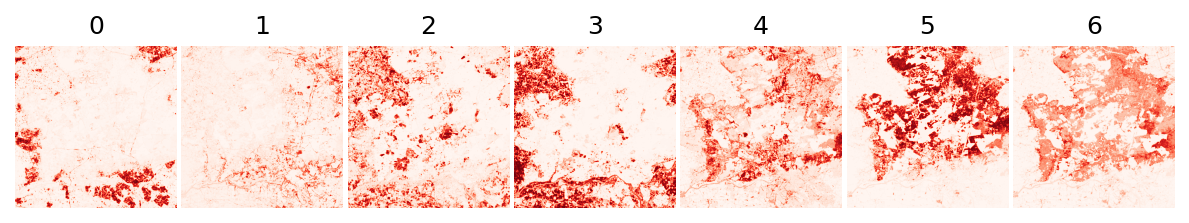

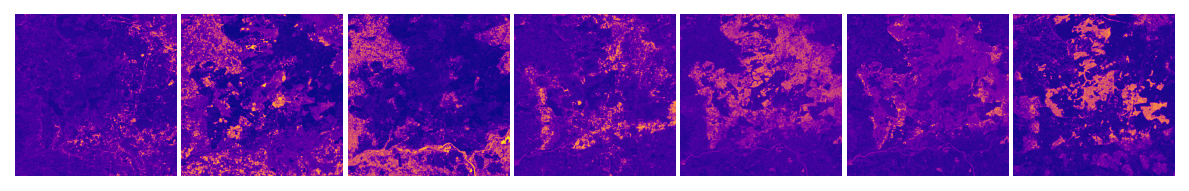

In [38]:
import numpy as np
from eumap.plotter import plot_rasters

estimator = landmapper.estimator_list[0]
print("Verifing the label order:")
for label, cl in zip(labels, estimator.classes_):
    print(f' - {cl:.0f} => {label}')

lc_classes = [ int(c) for c in landmapper.target_classes['transformed']]

plot_rasters(*output_fn_files[0:7], cmaps='Reds', titles=lc_classes , vertical_layout=False)
plot_rasters(*output_fn_files[11:19], cmaps='plasma')

This is the best model till now. Let's save it:

In [39]:
fn_joblib = raster_dir.joinpath('landmapper_eml.lz4')
landmapper.save_instance(fn_joblib)
fn_joblib

PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/landmapper_eml.lz4')